In [1]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
#from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget
import dsp_lib

In [2]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [3]:
from scipy.signal import butter, filtfilt
import os
from array import array
# def read_signal(file_name, data_type):
#     file_stats = os.stat(file_name)
#     file_size = file_stats.st_size
#     iq_size_in_bytes = 4
#     number_of_int_to_read = file_size // iq_size_in_bytes * 2
#     arr = array(data_type)
#     with open(file_path, 'rb') as fileobj:
#         arr.fromfile(fileobj, number_of_int_to_read)
#     i = np.array(arr[:: 2])
#     i = i.reshape((len(i), 1))
#     q = np.array(arr[1:: 2])
#     q = q.reshape((len(q), 1))
#     sig = np.empty((len(i), 1), complex)
#     sig.real = i
#     sig.imag = q
#     sig_flatten = sig.flatten()
#     return sig_flatten


# def find_carr_freq(spectrum, min_sig_lvl):
#     idx = list(np.where(spectrum >= min_sig_lvl))
#     idx = idx[0]
#     f_low = idx[0]
#     f_high = idx[-1]
#     carr_freq = round((f_low + f_high) / 2)
#     return carr_freq


# def mixing_signal(signal, freq):
#     N = len(signal)
#     k = freq
#     n = np.arange(0, N, 1)
#     mixer = np.exp(-1j * 2 * math.pi * k * n / N)
#     mixed_signal = np.multiply(signal, mixer)
#     return mixed_signal


# def filter_signal(mixed_sig, normal_cutoff):
#     order = 2
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     sig_filtered = filtfilt(b, a, mixed_sig)
#     return sig_filtered

In [4]:
# def resampling_lagrange_step_ver(s, step, x0):
#     """
#     % y = resample_lagrange(s, p, q, x0)
#     % Digital resampling by polynomial Lagrange interpolation.
#     % Function changes input signal s samplerate to p/q times and adds fractional
#     % delay.
#     %
#     % Input parameters
#     %  s   - input signal vector [N x 1];
#     %  p   - p paramter of samplarate conversion
#     %  q   - q paramter of samplarate conversion
#     %  x0  - fractional delay
#     %
#     % Ouptut parameters
#     %  y   - Resampled signal
#     %
#     % Author: Sergey Bakhurin (dsplib.org)
#     """
#     #if (p > 1):
#     #    if (q == 1):
#     #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
#     #    else:
#     #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
#     #else:
#     #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
#     if (step > 1):
#         y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
#     else:
#         y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
#     t = np.zeros(len(y))
#     s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

#     print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

#     for k in range(len(y)):
#         #x = k * q / p - x0
#         x = k * step - x0
#         t[k] = x
#         n = int(np.floor(x)) + 4
#         d = np.floor(x) + 1 - x
#         #print(f"x = {x}, n = {n}, d = {d}")
#         a0 = s[n - 1]
#         a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
#         a1 = 0.5 * (s[n] - s[n - 2]) - a3
#         a2 = s[n] - s[n - 1] - a3 - a1
#         #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
#         y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

#     #print(t)
#     return y

In [5]:
# def resampling_lagrange(s, p, q, x0):
#     """
#     % y = resample_lagrange(s, p, q, x0)
#     % Digital resampling by polynomial Lagrange interpolation.
#     % Function changes input signal s samplerate to p/q times and adds fractional
#     % delay.
#     %
#     % Input parameters
#     %  s   - input signal vector [N x 1];
#     %  p   - p paramter of samplarate conversion
#     %  q   - q paramter of samplarate conversion
#     %  x0  - fractional delay
#     %
#     % Ouptut parameters
#     %  y   - Resampled signal
#     %
#     % Author: Sergey Bakhurin (dsplib.org)
#     """
#     if (p > 1):
#         if (q == 1):
#             y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
#         else:
#             y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
#     else:
#         y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

#     t = np.zeros(len(y))
#     s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

#     for k in range(len(y)):
#         x = k * q / p - x0
#         t[k] = x
#         n = int(np.floor(x)) + 4
#         d = np.floor(x) + 1 - x
#         a0 = s[n - 1]
#         a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
#         a1 = 0.5 * (s[n] - s[n - 2]) - a3
#         a2 = s[n] - s[n - 1] - a3 - a1

#         y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

#     return y


In [6]:
# def calculate_spectrum(signal):
#     yf = np.fft.fft(signal)
#     yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
#     return yf


# def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
#     spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
#     yf = 20 * np.log10(spectrum)

#     plt.figure(figure_counter)
#     plt.cla()
#     x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
#     x_data = x_data / (len(spectrum) / 2)
#     plt.plot(x_data, yf)
#     plt.grid(1)
#     plt.xlabel('Frequency (semicircles)')
#     plt.ylabel('Magnitude (dB)')
#     plt.title(title)
#     plt.show()
#     return yf

# def add_freq(sig, f0_to_fsig):
#     n = np.arange(0, len(sig), 1)
#     mixer = np.exp(1j * np.pi * f0_to_fsig * n)
#     #print(mixer[(821500 - 10 -1) : (821500 - 1)])
#     return sig * mixer

In [7]:
# def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
#     assert (n % 2 == 1), "RRC filter length should be odd!"
#     n += 1 # because first sample will be not used
#     s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
#     return s_psf

In [8]:
# def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
#     assert (n % 2 == 1), "RC filter length should be odd!"
#     n += 1 # because first sample will be not used
#     s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
#     return s_psf

In [9]:
# def add_phase(sig, phase):
# # phase = [-1, 1] [semicircles]
#     sig *= np.exp(1j * np.pi * phase)
#     return sig

In [10]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

In [11]:
# a = [7, 3, 5, 2, 1, 4, 1]
# b = [2, 3, 4, 3, 2, 1]
# conv = np.convolve(a, b, 'same')
# print(conv)

In [12]:
# N = 7
# Fs = 1
# T_symb = 8#1 / sig_board
# s_rc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
# plot_signal_power(s_rc, 0)
#
# N_symb = 2
# sps = 8 # f_sampling / f_symbol (SPS)
# s_qpsk = gen_qpsk_symbols(N_symb, sps)
# print(s_qpsk)
# plot_signal_power(s_qpsk, 1)
#
# qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')
# print(qpsk_rc)
# plot_signal_power(qpsk_rc, 2)

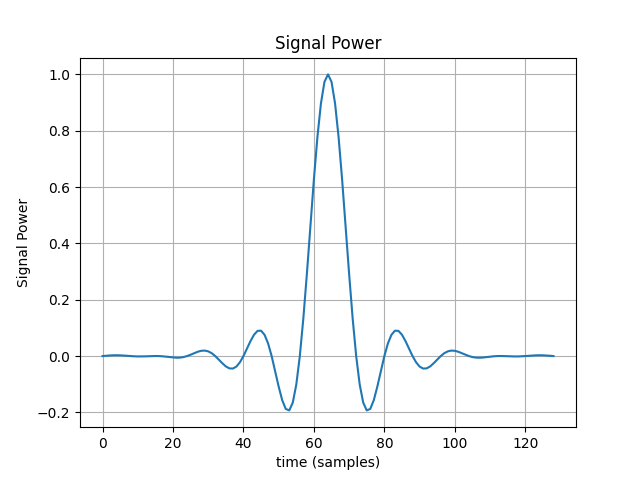

In [14]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = dsp_lib.gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 1000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = dsp_lib.gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [16]:
mixed_qpsk = dsp_lib.add_freq(qpsk_rc, 0.5)
mixed_qpsk = dsp_lib.add_phase(mixed_qpsk, 0.3)

In [17]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.631327654621755-1.4938281323586964j)
4.631327654621755
4.622477463743072
7075.077049947164


In [18]:
dsp_lib.save_cmplx_sig(two_sigs, 'qpsk_rc_float32.bid')

In [19]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
max(two_sigs)
two_sigs_upsc = upscale_to_i16(two_sigs)
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float.bin', 'float64')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)

129
1
8


NameError: name 'gen_rrc_filter_impulse_response' is not defined

129
1
8
(4.2801364075335036-1.4346860253412865j)
4.2801364075335036
4.269397016158872
7655.5971305789535
sig len = 1032000


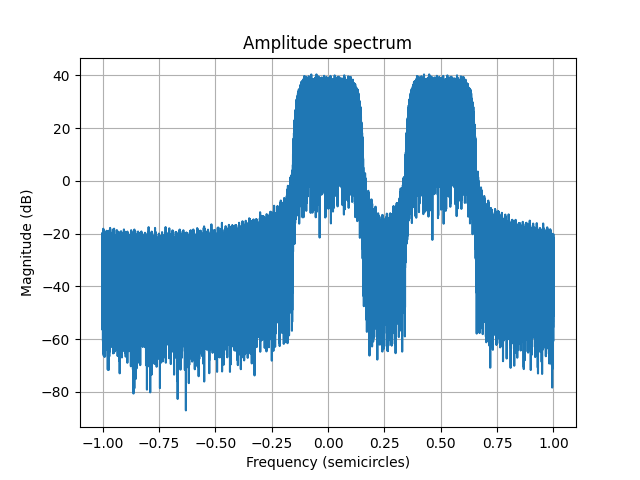

[-19776.62366153 +3566.13696301j  -6164.69327708 -2815.21410307j
   5484.42700504 +7935.85874496j   2356.2603398 +20255.7367688j
  -7545.76140673+18958.35200819j  -6180.78808402 +4667.97084932j
  12177.568577    -551.18196741j  21444.73373999+14558.35900136j
   7093.37614231+21812.20653175j  -2240.06726359 +6376.71854267j]


In [20]:
print(N)
print(Fs)
print(T_symb)
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = dsp_lib.add_freq(qpsk_rrc, 0.5)
mixed_qpsk = dsp_lib.add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
print(f"sig len = {len(two_sigs_upsc)}")
dsp_lib.save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float64.bin', 'float64')
dsp_lib.save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float32.bin', 'float32')
max(two_sigs_upsc)
dsp_lib.plot_spectrum(two_sigs_upsc, 10)
print(two_sigs_upsc[:10])

In [21]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])
print(s_rrc)
print(qpsk_rrc_rrc[:10])
print(qpsk_rrc_rrc[len(qpsk_rrc_rrc) - 10::])
# samples_32 = dsp_lib.read_signal('qpsk_rrc_float32.bin', 'float32')
# sig32 = dsp_lib.make_cmplx_sig(samples_32)
# print(sig32[:10])

[-19776.62366153 +3566.13696301j  -6164.69327708 -2815.21410307j
   5484.42700504 +7935.85874496j   2356.2603398 +20255.7367688j
  -7545.76140673+18958.35200819j  -6180.78808402 +4667.97084932j
  12177.568577    -551.18196741j  21444.73373999+14558.35900136j
   7093.37614231+21812.20653175j  -2240.06726359 +6376.71854267j]
[-5.27526056e-03 -3.99102742e-03 -1.64842729e-03  1.29551186e-03
  4.20829446e-03  6.41713384e-03  7.36294421e-03  6.73849224e-03
  4.57739857e-03  1.26984331e-03 -2.50378491e-03 -5.91158303e-03
 -8.15394430e-03 -8.65281056e-03 -7.20253053e-03 -4.04416717e-03
  1.59973235e-04  4.45338056e-03  7.79222114e-03  9.28996172e-03
  8.44532739e-03  5.29838667e-03  4.71398168e-04 -4.92610836e-03
 -9.51895698e-03 -1.19753744e-02 -1.13400852e-02 -7.31607595e-03
 -4.23543130e-04  8.01507220e-03  1.60811386e-02  2.16328990e-02
  2.27812262e-02  1.83734040e-02  8.37737184e-03 -5.93206756e-03
 -2.20523040e-02 -3.66153950e-02 -4.59937904e-02 -4.70527982e-02
 -3.79107833e-02 -1.85494

In [22]:
print(qpsk_rrc_rrc[:10])

[-3.04550122e+04+35441.43402886j -2.37280219e+04+51745.28850492j
 -1.32475154e+04+67552.85737091j  3.71406285e+01+81205.11429083j
  1.46226765e+04+90847.08734287j  2.89052336e+04+94778.1252111j
  4.12844584e+04+91974.7016912j   5.01167499e+04+82200.28199678j
  5.40036401e+04+65861.29768061j  5.22249080e+04+44086.64395035j]


In [23]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])

two_sigs_upsc_i16 = upscale_to_i16(qpsk_rrc_rrc)
dsp_lib.save_cmplx_sig_to_int16(two_sigs_upsc_i16, 'qpsk_rrc_rrc_int16_.bin')

dsplot_spectrum(qpsk_rrc_rrc, 1)


[-19776.62366153 +3566.13696301j  -6164.69327708 -2815.21410307j
   5484.42700504 +7935.85874496j   2356.2603398 +20255.7367688j
  -7545.76140673+18958.35200819j  -6180.78808402 +4667.97084932j
  12177.568577    -551.18196741j  21444.73373999+14558.35900136j
   7093.37614231+21812.20653175j  -2240.06726359 +6376.71854267j]
(120113.80691316712+4149.490459324968j)
120113.80691316712
120098.43854423916
0.2727996126514246


NameError: name 'save_cmplx_sig_to_int16' is not defined

In [24]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
plot_spectrum(qpsk_upsc, 2)

(1.951223413234675+0.07133171384753825j)
1.951223413234675
1.95332457732921
16774.98987126987


NameError: name 'plot_spectrum' is not defined

In [ ]:
save_cmplx_sig_to_int16(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin')